In [39]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms, models
from PIL import Image
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Device

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data loading and preprocessing

In [41]:
def load_captions(captions_path):
    """Load captions from CSV file"""
    captions = {}
    with open(captions_path, 'r') as f:
        next(f)  # skip header line
        for line in f:
            line = line.strip()
            if not line:
                continue
            img, caption = line.split(',', 1)
            captions.setdefault(img, []).append(caption.lower())
    return captions


In [42]:
def tokenize(text):
    """Simple tokenizer"""
    return text.lower().strip().split()

In [43]:
class Vocabulary:
    """Build vocabulary from captions"""
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {
            "<PAD>": 0,
            "<SOS>": 1,
            "<EOS>": 2,
            "<UNK>": 3
        }
        self.idx2word = {v: k for k, v in self.word2idx.items()}

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in tokenize(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word
                    idx += 1

    def numericalize(self, text):
        return [
            self.word2idx.get(word, self.word2idx["<UNK>"])
            for word in tokenize(text)
        ]

    def __len__(self):
        return len(self.word2idx)


## Dataset Class

In [44]:
class FlickrDataset(Dataset):
    """Flickr8k Dataset"""
    def __init__(self, image_dir, captions, vocab, transform=None):
        self.image_dir = image_dir
        self.captions = captions
        self.images = list(captions.keys())
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        caption = self.captions[img_name][0]  # Take first caption

        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        numericalized_caption = (
            [self.vocab.word2idx["<SOS>"]] +
            self.vocab.numericalize(caption) +
            [self.vocab.word2idx["<EOS>"]]
        )

        return image, torch.tensor(numericalized_caption)

In [45]:
def collate_fn(batch):
    """Custom collate function for DataLoader"""
    images = []
    captions = []

    for img, cap in batch:
        images.append(img)
        captions.append(cap)

    images = torch.stack(images)
    captions = pad_sequence(captions, batch_first=True, padding_value=0)

    return images, captions

## Model Architecture

In [46]:
class EncoderCNN(nn.Module):
    """CNN Encoder using pretrained ResNet50"""
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Freeze ResNet parameters
        for param in resnet.parameters():
            param.requires_grad = False
        
        # Remove final classification layer
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        
        # Custom FC layer with regularization
        self.fc = nn.Sequential(
            nn.Linear(resnet.fc.in_features, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.Dropout(0.5)
        )

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return features


In [47]:
class DecoderRNN(nn.Module):
    """LSTM Decoder for caption generation"""
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        super().__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=0.5 if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        outputs, _ = self.lstm(embeddings)
        outputs = self.fc(outputs)
        return outputs
    
    def generate_caption(self, features, vocab, max_length=20):
        """Generate caption using greedy search"""
        result = []
        states = None
        inputs = features.unsqueeze(1)
        
        for _ in range(max_length):
            outputs, states = self.lstm(inputs, states)
            outputs = self.fc(outputs.squeeze(1))
            predicted = outputs.argmax(1)
            result.append(predicted.item())
            
            if predicted.item() == vocab.word2idx["<EOS>"]:
                break
                
            inputs = self.embed(predicted).unsqueeze(1)
        
        return result
    
    def generate_caption_beam(self, features, vocab, beam_width=3, max_length=20):
        """Generate caption using beam search"""
        k = beam_width
        
        # Start with <SOS> token
        sequences = [[vocab.word2idx["<SOS>"]]]
        scores = [0.0]
        states_list = [None]
        
        for step in range(max_length):
            all_candidates = []
            
            for i, seq in enumerate(sequences):
                if seq[-1] == vocab.word2idx["<EOS>"]:
                    all_candidates.append((scores[i], seq, states_list[i]))
                    continue
                
                # Get input
                if step == 0:
                    inputs = features.unsqueeze(1)
                else:
                    inputs = self.embed(torch.tensor([seq[-1]]).to(features.device)).unsqueeze(1)
                
                # Forward pass
                outputs, states = self.lstm(inputs, states_list[i])
                outputs = self.fc(outputs.squeeze(1))
                log_probs = torch.log_softmax(outputs, dim=1)
                
                # Get top k predictions
                topk_probs, topk_indices = log_probs.topk(k, dim=1)
                
                for j in range(k):
                    candidate_seq = seq + [topk_indices[0][j].item()]
                    candidate_score = scores[i] + topk_probs[0][j].item()
                    all_candidates.append((candidate_score, candidate_seq, states))
            
            # Select top k sequences
            ordered = sorted(all_candidates, key=lambda x: x[0], reverse=True)
            sequences = [seq for score, seq, states in ordered[:k]]
            scores = [score for score, seq, states in ordered[:k]]
            states_list = [states for score, seq, states in ordered[:k]]
            
            # Check if all sequences have ended
            if all(seq[-1] == vocab.word2idx["<EOS>"] for seq in sequences):
                break
        
        # Return best sequence
        best_seq = sequences[0][1:]  # Skip <SOS>
        if best_seq and best_seq[-1] == vocab.word2idx["<EOS>"]:
            best_seq = best_seq[:-1]  # Remove <EOS>
        return best_seq

## Trainindg def

In [48]:
def train_model(encoder, decoder, train_loader, val_loader, criterion, optimizer, 
                num_epochs, device, save_path="best_model.pth"):
    """Train the model with validation"""
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )
    
    for epoch in range(num_epochs):
        # --- TRAINING ---
        encoder.train()
        decoder.train()
        total_train_loss = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, captions in train_bar:
            images, captions = images.to(device), captions.to(device)
            
            optimizer.zero_grad()
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1])
            
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), 
                captions.reshape(-1)
            )
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5)
            optimizer.step()
            
            total_train_loss += loss.item()
            train_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # --- VALIDATION ---
        encoder.eval()
        decoder.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)
                features = encoder(images)
                outputs = decoder(features, captions[:, :-1])
                loss = criterion(
                    outputs.reshape(-1, outputs.shape[2]), 
                    captions.reshape(-1)
                )
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update learning rate and track changes
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if new_lr != old_lr:
            print(f"Learning rate reduced: {old_lr:.2e} → {new_lr:.2e}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, save_path)
            print(f"✓ Saved best model (val_loss: {best_val_loss:.4f})")
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses

## inference functions

In [49]:
def generate_caption(image_path, encoder, decoder, vocab, transform, device, beam_search=True):
    """Generate caption for a single image"""
    encoder.eval()
    decoder.eval()
    
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(image)
        if beam_search:
            caption_indices = decoder.generate_caption_beam(features, vocab)
        else:
            caption_indices = decoder.generate_caption(features, vocab)
    
    caption = ' '.join([vocab.idx2word.get(idx, '<UNK>') for idx in caption_indices])
    return caption

In [80]:
def visualize_predictions_full(encoder, decoder, dataset, vocab, device, num_samples=5):
    """Visualize predictions on sample images with full captions (no truncation, no wrap)"""
    encoder.eval()
    decoder.eval()
    
    fig, axes = plt.subplots(1, num_samples, figsize=(6*num_samples, 6))
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        idx = torch.randint(0, len(dataset), (1,)).item()
        image, true_caption_idx = dataset[idx]
        
        with torch.no_grad():
            features = encoder(image.unsqueeze(0).to(device))
            # Replace with your generate_caption function
            pred_caption_idx = decoder.generate_caption_beam(features, vocab)
        
        # Convert indices to text
        true_caption = ' '.join([vocab.idx2word.get(idx, '<UNK>') 
                                 for idx in true_caption_idx.tolist()[1:-1]])
        pred_caption = ' '.join([vocab.idx2word.get(idx, '<UNK>') 
                                 for idx in pred_caption_idx])
        
        # Denormalize image
        img = image.permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_caption}\nPred: {pred_caption}", fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [51]:
def plot_losses(train_losses, val_losses):
    """Plot training and validation losses"""
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-s', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [52]:
def evaluate_on_test(encoder, decoder, test_loader, criterion, device):
    """Evaluate model on test set"""
    encoder.eval()
    decoder.eval()
    total_loss = 0
    
    print("\nEvaluating on test set...")
    with torch.no_grad():
        for images, captions in tqdm(test_loader, desc="Testing"):
            images, captions = images.to(device), captions.to(device)
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), 
                captions.reshape(-1)
            )
            total_loss += loss.item()
    
    avg_test_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")
    return avg_test_loss

In [53]:
def calculate_bleu_score(encoder, decoder, test_dataset, vocab, device, num_samples=100):
    """Calculate BLEU score on test set (simple version)"""
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    
    encoder.eval()
    decoder.eval()
    
    bleu_scores = []
    smoothing = SmoothingFunction().method1
    
    print(f"\nCalculating BLEU scores on {num_samples} samples...")
    for i in tqdm(range(min(num_samples, len(test_dataset)))):
        image, true_caption_idx = test_dataset[i]
        
        # Generate caption
        with torch.no_grad():
            features = encoder(image.unsqueeze(0).to(device))
            pred_caption_idx = decoder.generate_caption_beam(features, vocab)
        
        # Convert to words (remove special tokens)
        true_words = [vocab.idx2word.get(idx, '<UNK>') 
                     for idx in true_caption_idx.tolist()[1:-1]]  # Remove <SOS> and <EOS>
        pred_words = [vocab.idx2word.get(idx, '<UNK>') 
                     for idx in pred_caption_idx]
        
        # Calculate BLEU score
        score = sentence_bleu([true_words], pred_words, smoothing_function=smoothing)
        bleu_scores.append(score)
    
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU Score: {avg_bleu:.4f}")
    return avg_bleu

# Execution

In [54]:
captions_path = "/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt"
image_dir = "/kaggle/input/flickr8kimagescaptions/flickr8k/images"

In [55]:
embed_size = 256
hidden_size = 512
num_layers = 2
batch_size = 32
num_epochs = 15
learning_rate = 3e-4

In [56]:
captions = load_captions(captions_path)
print(f"Loaded {len(captions)} images with captions")

Loaded 8091 images with captions


In [57]:
vocab = Vocabulary(freq_threshold=5)
all_captions = [cap for caps in captions.values() for cap in caps]
vocab.build_vocab(all_captions)
vocab_size = len(vocab.word2idx)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 3040


In [58]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [59]:
full_dataset = FlickrDataset(image_dir, captions, vocab, train_transform)


In [60]:
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

In [61]:
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform    

In [62]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fn, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fn, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fn, num_workers=2
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 6472
Validation samples: 809
Test samples: 810


In [64]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)    

In [65]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(
    list(encoder.fc.parameters()) + list(decoder.parameters()),
    lr=learning_rate,
    weight_decay=1e-5
)

In [66]:
print(f"Encoder parameters: {sum(p.numel() for p in encoder.parameters() if p.requires_grad):,}")
print(f"Decoder parameters: {sum(p.numel() for p in decoder.parameters() if p.requires_grad):,}")    

Encoder parameters: 525,056
Decoder parameters: 6,015,968


## Training start

In [67]:
train_losses, val_losses = train_model(
    encoder, decoder, train_loader, val_loader,
    criterion, optimizer, num_epochs, device,
    save_path="best_caption_model.pth"
)

Epoch 1/15 [Train]: 100%|██████████| 203/203 [00:38<00:00,  5.26it/s, loss=4.08]


✓ Saved best model (val_loss: 4.0026)
Epoch [1/15] Train Loss: 4.9169 | Val Loss: 4.0026


Epoch 2/15 [Train]: 100%|██████████| 203/203 [00:29<00:00,  6.94it/s, loss=3.49]


✓ Saved best model (val_loss: 3.6117)
Epoch [2/15] Train Loss: 3.7677 | Val Loss: 3.6117


Epoch 3/15 [Train]: 100%|██████████| 203/203 [00:27<00:00,  7.38it/s, loss=3.5] 


✓ Saved best model (val_loss: 3.4335)
Epoch [3/15] Train Loss: 3.4913 | Val Loss: 3.4335


Epoch 4/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.17it/s, loss=3.2] 


✓ Saved best model (val_loss: 3.3143)
Epoch [4/15] Train Loss: 3.3260 | Val Loss: 3.3143


Epoch 5/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.18it/s, loss=2.99]


✓ Saved best model (val_loss: 3.2338)
Epoch [5/15] Train Loss: 3.2062 | Val Loss: 3.2338


Epoch 6/15 [Train]: 100%|██████████| 203/203 [00:27<00:00,  7.28it/s, loss=2.99]


✓ Saved best model (val_loss: 3.1703)
Epoch [6/15] Train Loss: 3.1127 | Val Loss: 3.1703


Epoch 7/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.25it/s, loss=2.74]


✓ Saved best model (val_loss: 3.1156)
Epoch [7/15] Train Loss: 3.0341 | Val Loss: 3.1156


Epoch 8/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.18it/s, loss=2.71]


✓ Saved best model (val_loss: 3.0666)
Epoch [8/15] Train Loss: 2.9614 | Val Loss: 3.0666


Epoch 9/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.21it/s, loss=2.18]


✓ Saved best model (val_loss: 3.0161)
Epoch [9/15] Train Loss: 2.8930 | Val Loss: 3.0161


Epoch 10/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.24it/s, loss=2.85]


✓ Saved best model (val_loss: 2.9775)
Epoch [10/15] Train Loss: 2.8342 | Val Loss: 2.9775


Epoch 11/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.21it/s, loss=2.43]


✓ Saved best model (val_loss: 2.9486)
Epoch [11/15] Train Loss: 2.7743 | Val Loss: 2.9486


Epoch 12/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.18it/s, loss=2.4] 


✓ Saved best model (val_loss: 2.9199)
Epoch [12/15] Train Loss: 2.7234 | Val Loss: 2.9199


Epoch 13/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.23it/s, loss=2.57]


✓ Saved best model (val_loss: 2.8820)
Epoch [13/15] Train Loss: 2.6771 | Val Loss: 2.8820


Epoch 14/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.23it/s, loss=2.59]


✓ Saved best model (val_loss: 2.8732)
Epoch [14/15] Train Loss: 2.6292 | Val Loss: 2.8732


Epoch 15/15 [Train]: 100%|██████████| 203/203 [00:28<00:00,  7.19it/s, loss=2.68]


✓ Saved best model (val_loss: 2.8337)
Epoch [15/15] Train Loss: 2.5870 | Val Loss: 2.8337


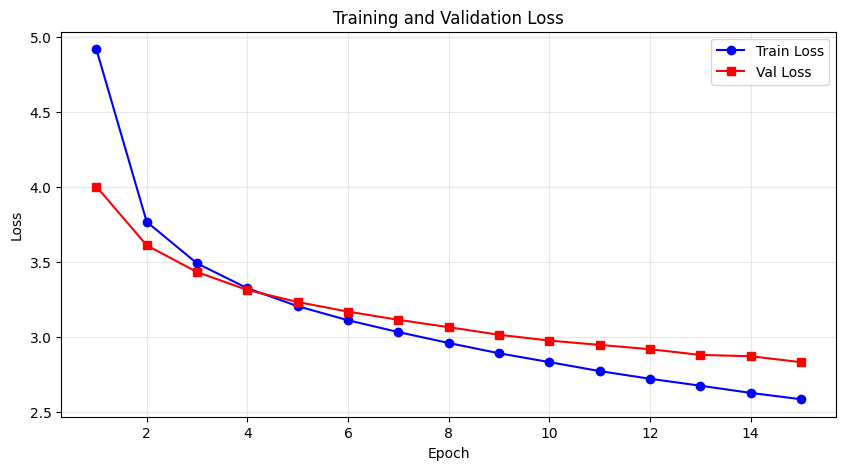

In [68]:
plot_losses(train_losses, val_losses)

In [69]:
    checkpoint = torch.load("best_caption_model.pth")
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    

<All keys matched successfully>

In [70]:
    test_loss = evaluate_on_test(encoder, decoder, test_loader, criterion, device)
 


Evaluating on test set...


Testing: 100%|██████████| 26/26 [00:06<00:00,  4.18it/s]

Test Loss: 2.8214


In [71]:
try:
    import nltk
    nltk.download('punkt', quiet=True)
    bleu_score = calculate_bleu_score(encoder, decoder, test_dataset, vocab, device, num_samples=100)
except ImportError:
    print("NLTK not installed. Skipping BLEU score calculation.")
    print("Install with: pip install nltk")



Calculating BLEU scores on 100 samples...


100%|██████████| 100/100 [00:03<00:00, 27.55it/s]

Average BLEU Score: 0.0470


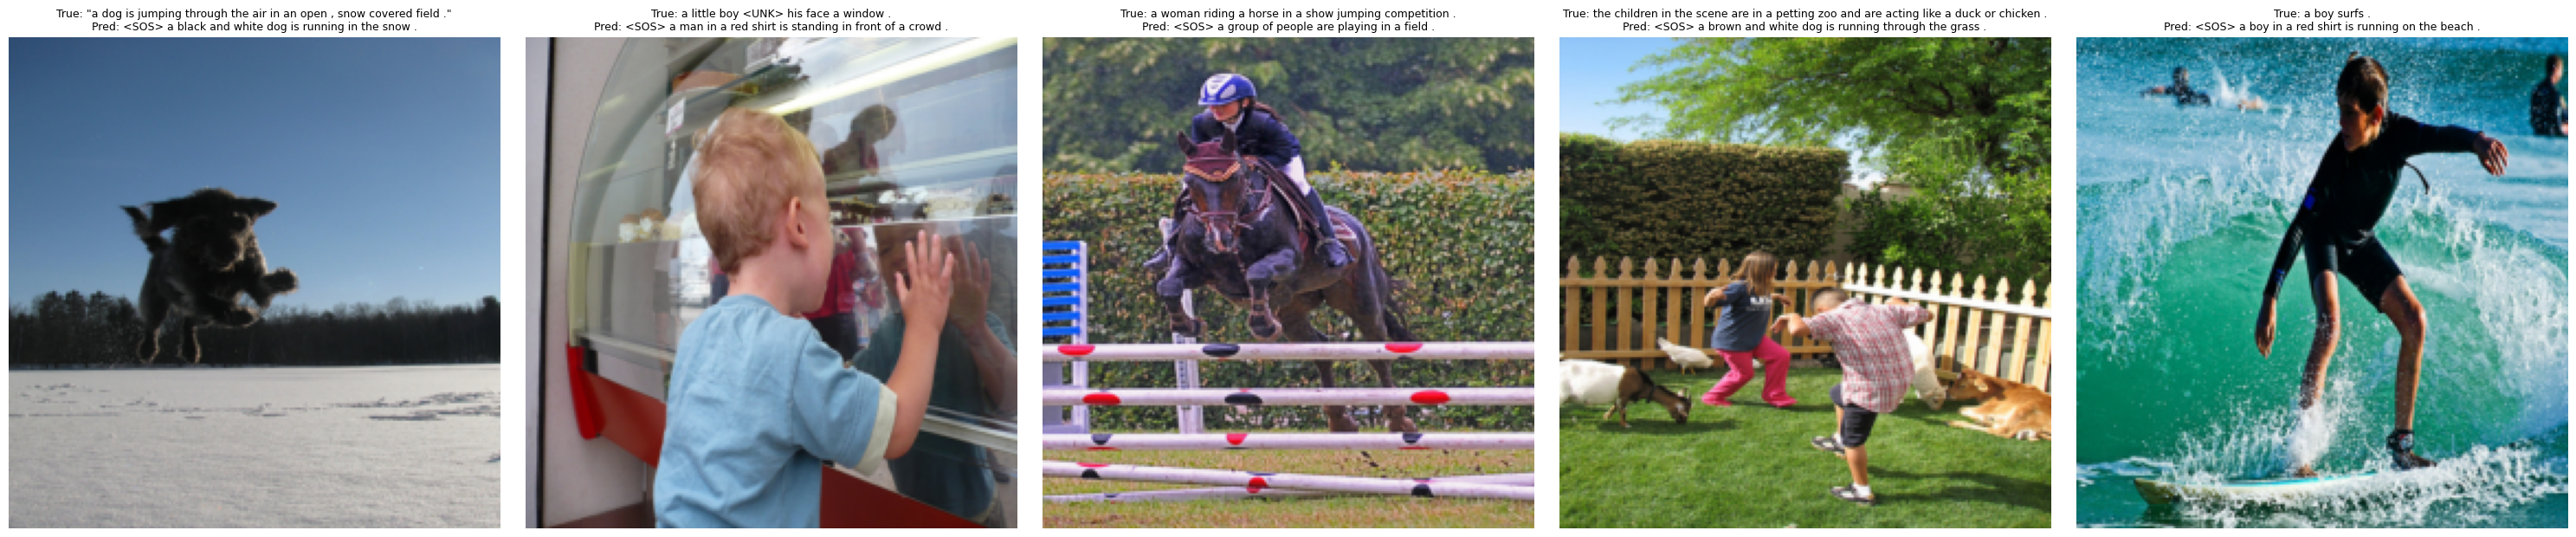

In [83]:
visualize_predictions_full(encoder, decoder, test_dataset, vocab, device, num_samples=5)

In [73]:
    torch.save({
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict(),
        'vocab': vocab.word2idx,
        'idx2word': vocab.idx2word,
        'embed_size': embed_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers
    }, "final_caption_model.pth")
    
    print("✓ Training complete! Model saved.")

✓ Training complete! Model saved.
